<a href="https://colab.research.google.com/github/sydsaenz/18.065FinalProject/blob/main/18_065FinalProjectModel1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns


In [3]:


url = "https://raw.githubusercontent.com/sydsaenz/18.065FinalProject/main/team_features.csv"
team_data = pd.read_csv(url).drop(columns=["index"])

team_data

,TeamID,Season,seed_num,weighted_past_seed,3pt_success_rate,freethrow_success_rate,field_success_rate
0,1101,1985,17.0,17.00000,0.362112,0.705516,0.432431
1,1101,1986,17.0,17.00000,0.362112,0.705516,0.432431
2,1101,1987,17.0,17.00000,0.362112,0.705516,0.432431
3,1101,1988,17.0,17.00000,0.362112,0.705516,0.432431
4,1101,1989,17.0,17.00000,0.362112,0.705516,0.432431
...,...,...,...,...,...,...,...
12828,1471,2021,17.0,17.00000,0.369792,0.607362,0.459770
12829,1471,2022,17.0,17.00000,0.359636,0.746809,0.437413
12830,1471,2023,17.0,17.00000,0.330128,0.739759,0.431175
12831,1471,2024,17.0,17.00000,0.344733,0.750883,0.448394


In [12]:
for col in team_data.columns:
  print(col)
  print(team_data[col].describe())
  print("------------------------------------------")

index
count    12833.000000
mean      6416.000000
std       3704.712337
min          0.000000
25%       3208.000000
50%       6416.000000
75%       9624.000000
max      12832.000000
Name: index, dtype: float64
------------------------------------------
TeamID
count    12833.000000
mean      1282.696486
std        103.573835
min       1101.000000
25%       1196.000000
50%       1281.000000
75%       1372.000000
max       1471.000000
Name: TeamID, dtype: float64
------------------------------------------
Season
count    12833.000000
mean      2005.000000
std         11.832621
min       1985.000000
25%       1995.000000
50%       2005.000000
75%       2015.000000
max       2025.000000
Name: Season, dtype: float64
------------------------------------------
seed_num
count    12833.000000
mean        15.288865
std          3.975123
min          1.000000
25%         17.000000
50%         17.000000
75%         17.000000
max         17.000000
Name: seed_num, dtype: float64
---------------------

In [6]:
# 12833 rows. number of unique rows:
len(team_data[["TeamID", "Season"]].drop_duplicates())

12833

In [9]:
url = "https://raw.githubusercontent.com/sydsaenz/18.065FinalProject/main/MNCAATourneyCompactResults.csv"
matches_raw = pd.read_csv(url) #.drop(columns=["index"])

matches_raw

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0
...,...,...,...,...,...,...,...,...
2513,2024,146,1301,76,1181,64,N,0
2514,2024,146,1345,72,1397,66,N,0
2515,2024,152,1163,86,1104,72,N,0
2516,2024,152,1345,63,1301,50,N,0


In [10]:
matches = matches_raw[["Season","WTeamID","LTeamID"]]

In [18]:
# make dataframe with combined winner and loser data for all matches
matches_W = pd.merge(left=matches,right=team_data, left_on=["Season","WTeamID"], right_on=["Season","TeamID"], how="left").drop(columns=["TeamID"])
cols_to_rename = list(set(team_data.columns)-{"Season","TeamID"})
W_names = {n:n+"_W" for n in cols_to_rename}
matches_W.rename(columns=W_names, inplace=True)
matches_WL = pd.merge(left=matches_W,right=team_data, left_on=["Season","LTeamID"], right_on=["Season","TeamID"], how="left").drop(columns=["TeamID"])
L_names = {n:n+"_L" for n in cols_to_rename}
matches_WL.rename(columns=L_names, inplace=True)
matches_WL

,Season,WTeamID,LTeamID,seed_num_W,weighted_past_seed_W,3pt_success_rate_W,freethrow_success_rate_W,field_success_rate_W,seed_num_L,weighted_past_seed_L,3pt_success_rate_L,freethrow_success_rate_L,field_success_rate_L
0,1985,1116,1234,9.0,9.000000,0.337744,0.669443,0.437813,8.0,8.000000,0.345894,0.704658,0.447840
1,1985,1120,1345,11.0,11.000000,0.344374,0.663121,0.443238,6.0,6.000000,0.329985,0.707424,0.439642
2,1985,1207,1250,1.0,1.000000,0.351575,0.714259,0.453702,16.0,16.000000,0.346186,0.708815,0.412565
3,1985,1229,1425,9.0,9.000000,0.367681,0.661989,0.439417,8.0,8.000000,0.349069,0.671232,0.440966
4,1985,1242,1325,3.0,3.000000,0.361299,0.678938,0.477377,14.0,14.000000,0.345948,0.703845,0.444500
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2513,2024,1301,1181,11.0,13.237115,0.346049,0.733520,0.449203,4.0,3.647542,0.377119,0.721875,0.481794
2514,2024,1345,1397,1.0,7.671132,0.408012,0.721212,0.488324,2.0,10.931864,0.341912,0.749263,0.444332
2515,2024,1163,1104,1.0,9.102944,0.366871,0.742470,0.495988,4.0,11.536523,0.365325,0.783562,0.477317
2516,2024,1345,1301,1.0,7.671132,0.408012,0.721212,0.488324,11.0,13.237115,0.346049,0.733520,0.449203


In [24]:
for col in cols_to_rename:
  matches_WL[col+"_diff"] = matches_WL[col+"_W"] - matches_WL[col+"_L"]

matches_WL

,Season,WTeamID,LTeamID,seed_num_W,weighted_past_seed_W,3pt_success_rate_W,freethrow_success_rate_W,field_success_rate_W,seed_num_L,weighted_past_seed_L,3pt_success_rate_L,freethrow_success_rate_L,field_success_rate_L,weighted_past_seed_diff,field_success_rate_diff,seed_num_diff,3pt_success_rate_diff,freethrow_success_rate_diff
0,1985,1116,1234,9.0,9.000000,0.337744,0.669443,0.437813,8.0,8.000000,0.345894,0.704658,0.447840,1.000000,-0.010027,1.0,-0.008150,-0.035215
1,1985,1120,1345,11.0,11.000000,0.344374,0.663121,0.443238,6.0,6.000000,0.329985,0.707424,0.439642,5.000000,0.003596,5.0,0.014389,-0.044302
2,1985,1207,1250,1.0,1.000000,0.351575,0.714259,0.453702,16.0,16.000000,0.346186,0.708815,0.412565,-15.000000,0.041138,-15.0,0.005389,0.005444
3,1985,1229,1425,9.0,9.000000,0.367681,0.661989,0.439417,8.0,8.000000,0.349069,0.671232,0.440966,1.000000,-0.001549,1.0,0.018613,-0.009242
4,1985,1242,1325,3.0,3.000000,0.361299,0.678938,0.477377,14.0,14.000000,0.345948,0.703845,0.444500,-11.000000,0.032877,-11.0,0.015352,-0.024906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2513,2024,1301,1181,11.0,13.237115,0.346049,0.733520,0.449203,4.0,3.647542,0.377119,0.721875,0.481794,9.589573,-0.032591,7.0,-0.031070,0.011645
2514,2024,1345,1397,1.0,7.671132,0.408012,0.721212,0.488324,2.0,10.931864,0.341912,0.749263,0.444332,-3.260732,0.043992,-1.0,0.066100,-0.028050
2515,2024,1163,1104,1.0,9.102944,0.366871,0.742470,0.495988,4.0,11.536523,0.365325,0.783562,0.477317,-2.433579,0.018671,-3.0,0.001546,-0.041092
2516,2024,1345,1301,1.0,7.671132,0.408012,0.721212,0.488324,11.0,13.237115,0.346049,0.733520,0.449203,-5.565984,0.039121,-10.0,0.061963,-0.012308


In [27]:
matches_diff = matches_WL[[col for col in matches_WL.columns if "diff" in col]]
matches_diff["team_1_win"] = 1
matches_diff

<ipython-input-27-1bcbc1f8d440>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matches_diff["team_1_win"] = 1


,weighted_past_seed_diff,field_success_rate_diff,seed_num_diff,3pt_success_rate_diff,freethrow_success_rate_diff,team_1_win
0,1.000000,-0.010027,1.0,-0.008150,-0.035215,1
1,5.000000,0.003596,5.0,0.014389,-0.044302,1
2,-15.000000,0.041138,-15.0,0.005389,0.005444,1
3,1.000000,-0.001549,1.0,0.018613,-0.009242,1
4,-11.000000,0.032877,-11.0,0.015352,-0.024906,1
...,...,...,...,...,...,...
2513,9.589573,-0.032591,7.0,-0.031070,0.011645,1
2514,-3.260732,0.043992,-1.0,0.066100,-0.028050,1
2515,-2.433579,0.018671,-3.0,0.001546,-0.041092,1
2516,-5.565984,0.039121,-10.0,0.061963,-0.012308,1


In [33]:
matches_diff_negated = matches_diff.copy()
# adding 10000 to the index so they are unique but also so i can find the corresponding pair easily
matches_diff_negated.index = matches_diff.index+ np.ones_like(matches_diff.index)*10000
matches_diff_negated = -matches_diff_negated
matches_diff_negated["team_1_win"] = 0
matches_diff_negated

,weighted_past_seed_diff,field_success_rate_diff,seed_num_diff,3pt_success_rate_diff,freethrow_success_rate_diff,team_1_win
10000,-1.000000,0.010027,-1.0,0.008150,0.035215,0
10001,-5.000000,-0.003596,-5.0,-0.014389,0.044302,0
10002,15.000000,-0.041138,15.0,-0.005389,-0.005444,0
10003,-1.000000,0.001549,-1.0,-0.018613,0.009242,0
10004,11.000000,-0.032877,11.0,-0.015352,0.024906,0
...,...,...,...,...,...,...
12513,-9.589573,0.032591,-7.0,0.031070,-0.011645,0
12514,3.260732,-0.043992,1.0,-0.066100,0.028050,0
12515,2.433579,-0.018671,3.0,-0.001546,0.041092,0
12516,5.565984,-0.039121,10.0,-0.061963,0.012308,0


In [35]:
model_dataset = pd.concat([matches_diff, matches_diff_negated])
model_dataset

,weighted_past_seed_diff,field_success_rate_diff,seed_num_diff,3pt_success_rate_diff,freethrow_success_rate_diff,team_1_win
0,1.000000,-0.010027,1.0,-0.008150,-0.035215,1
1,5.000000,0.003596,5.0,0.014389,-0.044302,1
2,-15.000000,0.041138,-15.0,0.005389,0.005444,1
3,1.000000,-0.001549,1.0,0.018613,-0.009242,1
4,-11.000000,0.032877,-11.0,0.015352,-0.024906,1
...,...,...,...,...,...,...
12513,-9.589573,0.032591,-7.0,0.031070,-0.011645,0
12514,3.260732,-0.043992,1.0,-0.066100,0.028050,0
12515,2.433579,-0.018671,3.0,-0.001546,0.041092,0
12516,5.565984,-0.039121,10.0,-0.061963,0.012308,0


In [46]:
# model
X = model_dataset.drop('team_1_win', axis=1)
y = model_dataset['team_1_win']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

logreg = LogisticRegression(max_iter=1000) # Increased max_iter for convergence
logreg.fit(X_train, y_train)

#
y_pred_train = logreg.predict(X_train)

y_pred = logreg.predict(X_test)
y_pred_prob = logreg.predict_proba(X_test)[:, 1]

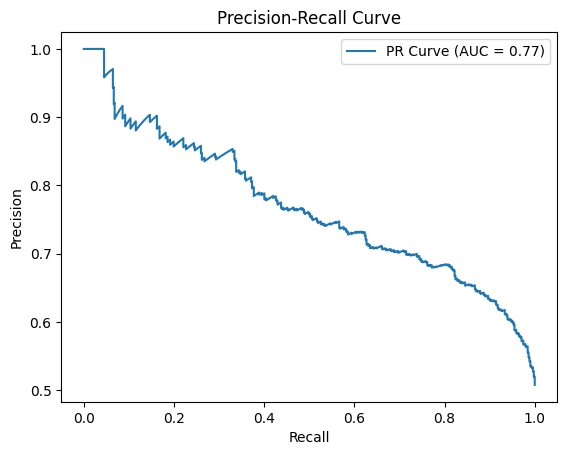

In [48]:
# precision recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
pr_auc = auc(recall, precision)

plt.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


In [52]:
test_accuracy = accuracy_score(y_test, y_pred)
train_accuracy = accuracy_score(y_train, y_pred_train)
print(f"{test_accuracy=}        {train_accuracy=}")

test_precision = precision_score(y_test, y_pred)
train_precision = precision_score(y_train, y_pred_train)
print(f"{test_precision=}        {train_precision=}")


test_recall = recall_score(y_test, y_pred)
train_recall = recall_score(y_train, y_pred_train)
print(f"{test_recall=}        {train_recall=}")


test_f1 = f1_score(y_test, y_pred)
train_f1 = f1_score(y_train, y_pred_train)
print(f"{test_f1=}        {train_f1=}")

test_accuracy=0.6984126984126984        train_accuracy=0.7149950347567031
test_precision=0.6984732824427481        train_precision=0.7140718562874252
test_recall=0.71484375        train_recall=0.7133599202392822
test_f1=0.7065637065637066        train_f1=0.7137157107231921


In [53]:
test_conf_matrix = confusion_matrix(y_test, y_pred)
train_conf_matrix = confusion_matrix(y_train, y_pred_train)

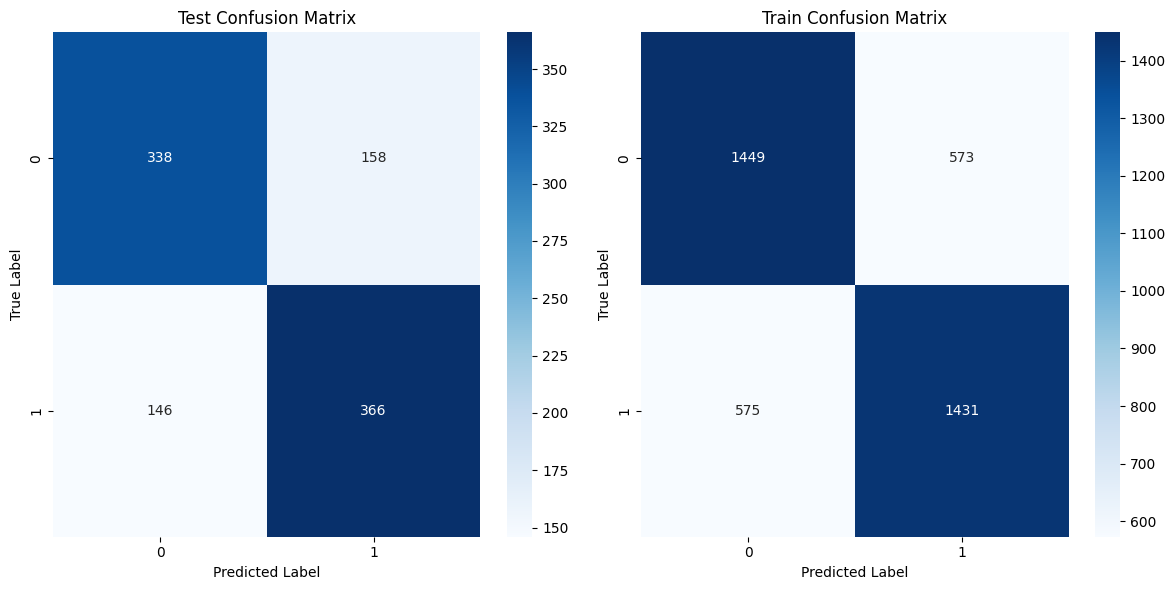

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.heatmap(test_conf_matrix, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("Test Confusion Matrix")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

sns.heatmap(train_conf_matrix, annot=True, fmt="d", cmap="Blues", ax=axes[1])
axes[1].set_title("Train Confusion Matrix")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")

plt.tight_layout()
plt.show()

In [55]:
logreg_full = LogisticRegression(max_iter=1000) # Increased max_iter for convergence
logreg_full.fit(X, y)

LogisticRegression(max_iter=1000)